# This notebook takles only the neural network part of the project

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
np.random.seed(42)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import tensorflow as tf
from tensorflow import keras

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     cross_val_predict, cross_validate, 
                                     RandomizedSearchCV)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, confusion_matrix)

In [3]:
development_toolkit_dir = 'C:/Users/Utilisateur/Documents/ECAM/ANNEE HERIOT WATT/Machine Learning & Data mining/ML & DM Project/DataSet/development_kit/data'
image_train_dir = 'C:/Users/Utilisateur/Documents/ECAM/ANNEE HERIOT WATT/Machine Learning & Data mining/ML & DM Project/DataSet/images/'

In [4]:
images=[] #This list will contain every images read through opencv
train_txt= '/train.txt' #This is the file giving the location of every images for the training set
categories_txt = '/categories.txt'

In [5]:
#We load the development kit tool to prepare the dataset
path = development_toolkit_dir + train_txt 
file = open(path,'r') 
#We open the txt folder, read through each lines and store them in the 'lines' list
lines = file.readlines()
file.close()
#Create a 100,000 long list that will store the location of every train set images
filename= [None]*len(lines)
i=0
index= []

for line in lines:
    #tmp[line]=line.split(" ")
    #print(line[:-3])
    filename[i]=line[:-3] #Keep the entire string up to the last 3 characters corresponding to the categories
    tmp=line[-3:-1]
    index.append(int(tmp))
    i=i+1 #increment
    


In [6]:
categories_file = open(f'{development_toolkit_dir}{categories_txt}', 'r') 
category_records = categories_file.readlines()
categories_file.close()

In [7]:
categories_dataset = []
for category_record in category_records:
    category_name, category_id = category_record.split(" ")
    category_name = category_name[3:].replace('/','-')
    
    categories_dataset.append(category_name)

In [8]:
#Create Image dataset
for image_path in filename:
    image_w= cv2.imread(f'{image_train_dir}/{image_path}', cv2.IMREAD_COLOR)
    image_bw = cv2.cvtColor(image_w, cv2.COLOR_BGR2GRAY)
    image_bw = cv2.resize(image_bw, (28,28), interpolation=cv2.INTER_AREA)
    images.append(image_bw)
    
                

In [9]:
#Verify the type of data we are working with, we want 128*128 images in greyscale
print(image_bw.shape, type(image_bw))

(28, 28) <class 'numpy.ndarray'>


(28, 28)


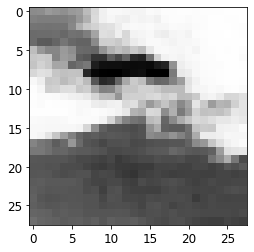

In [10]:
#Verify again by plotting the last processed image
plt.figure()
plt.imshow(image_bw, cmap='Greys')
print(image_bw.shape)

In [11]:
images_arr = np.stack(images)
images_arr_rsz = images_arr.reshape((len(images),-1))

In [12]:
#The data is shaped to represent each pictures through a list of 128*128 elements in grayscale
print(images_arr.shape)

(100000, 28, 28)


In [13]:
#let us now convert the dataframe into a panda structure to be able to use it with non convolutional network
df = pd.DataFrame(data=images_arr_rsz,
                  columns=['pixels_'+str(i+1) for i in range(images_arr_rsz.shape[1])])

In [14]:
# df['index'] = index
df

,pixels_1,pixels_2,pixels_3,pixels_4,pixels_5,pixels_6,pixels_7,pixels_8,pixels_9,pixels_10,...,pixels_775,pixels_776,pixels_777,pixels_778,pixels_779,pixels_780,pixels_781,pixels_782,pixels_783,pixels_784
0,62,61,67,55,80,97,99,101,103,103,...,131,122,112,91,73,61,140,77,78,76
1,118,141,216,250,252,254,254,252,229,251,...,107,107,108,105,104,96,89,117,111,86
2,214,221,230,238,244,244,243,245,248,250,...,115,110,114,110,80,74,86,68,46,27
3,24,57,100,149,106,88,123,59,33,36,...,20,21,21,21,22,21,21,21,22,24
4,128,129,129,128,128,128,128,128,128,127,...,105,106,110,108,107,109,112,115,115,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,216,213,224,247,250,252,254,251,253,254,...,93,100,102,94,87,95,96,96,89,86
99996,10,9,8,9,9,8,8,8,10,11,...,97,91,82,81,76,68,64,59,42,33
99997,246,241,174,140,93,67,45,33,31,22,...,46,56,74,61,58,49,62,83,96,78
99998,70,53,93,109,85,56,110,89,70,88,...,53,20,13,39,31,41,59,97,188,187


### Splitting the dataset as 0.9/0.1

We want to process the data and put them in correct format and size for one to train a network. We will consider using 90% of the data as training and the remaining 10% as testing data. We only consider the first 20,000 images which corresponds to 20 categories, doing so allows for lighter computation and easier optimization of network.

In [15]:
index_arr = np.array(index)

In [16]:
index_arr = index_arr[:20000]

In [17]:
images_arr = images_arr[:20000]

In [18]:
images_arr.shape

(20000, 28, 28)

The splitting of the data includes a shuffling, as such images in the X_test are highly likely to posess examples for each of the first 20 categories.

In [19]:
X_test, X_train_inventory, y_test, y_train_inventory = train_test_split(images_arr, index_arr, test_size=0.90, random_state=42, stratify=index_arr)

In [20]:
X_train_inventory.shape

(18000, 28, 28)

In [21]:
X_train, X_valid = X_train_inventory[:16000], X_train_inventory[16000:]
y_train, y_valid = y_train_inventory[:16000], y_train_inventory[16000:]

Here is an example of a random image and its category

In [22]:
print(categories_dataset[y_train[205]])

bakery-shop


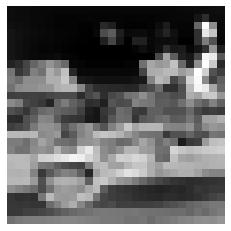

In [23]:
plt.imshow(X_train[205], cmap="binary")
plt.axis('off')
plt.show()

# Using the Multi Layer Perception

Multi layer perception is a kind of neural network in three parts designating groups of layers. The input and output layers and the hidden ones which are "in-between". They can be used to solve complex nonlinear problems because of their high adapdability to the scale of the dataset

## Building the network

This network is modeled as an input layer of 784 inputs (28*28), two 512 neurons layers and a last layer of size 20, one neuron for each class.

In [81]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # first layer convert each input image into a 1D array
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
model.add(keras.layers.Dense(512, activation="relu")) #hidden layer with 300 neurons useing the ReLU activation function.
#hidden layer with 100 neurons using the ReLU

model.add(keras.layers.Dense(20, activation="softmax")) #output layer with 20 neurons (one per class), using the softmax 

In [82]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 20)                10260     
                                                                 
Total params: 674,836
Trainable params: 674,836
Non-trainable params: 0
_________________________________________________________________


## Training the network

In [84]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", #"sgd" simply means that we will train the model using simple Stochastic Gradient Descent
              metrics=["accuracy"])

In [85]:
history = model.fit(X_train, y_train, batch_size=256, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
63/63 [==============================] - 3s 24ms/step - loss: 51.9963 - accuracy: 0.0549 - val_loss: 5.0151 - val_accuracy: 0.0625
Epoch 2/30
63/63 [==============================] - 1s 19ms/step - loss: 3.6903 - accuracy: 0.0677 - val_loss: 3.2354 - val_accuracy: 0.0690
Epoch 3/30
63/63 [==============================] - 1s 19ms/step - loss: 3.0556 - accuracy: 0.0791 - val_loss: 3.0405 - val_accuracy: 0.0930
Epoch 4/30
63/63 [==============================] - 1s 18ms/step - loss: 2.9493 - accuracy: 0.0904 - val_loss: 3.0068 - val_accuracy: 0.0910
Epoch 5/30
63/63 [==============================] - 1s 19ms/step - loss: 2.9126 - accuracy: 0.1024 - val_loss: 2.9910 - val_accuracy: 0.0920
Epoch 6/30
63/63 [==============================] - 2s 24ms/step - loss: 2.8825 - accuracy: 0.1101 - val_loss: 2.9777 - val_accuracy: 0.0940
Epoch 7/30
63/63 [==============================] - 1s 20ms/step - loss: 2.8558 - accuracy: 0.1174 - val_loss: 2.9827 - val_accuracy: 0.0995
Epoch 8/30
6

### Network training curve & evaluation

The metrics given during the training already gives us an insight on the accuracy of our trained network. However, one can visualize the evolution of traning over epochs as well as evaluate it with our testing set (20% of the entire dataset in our case)

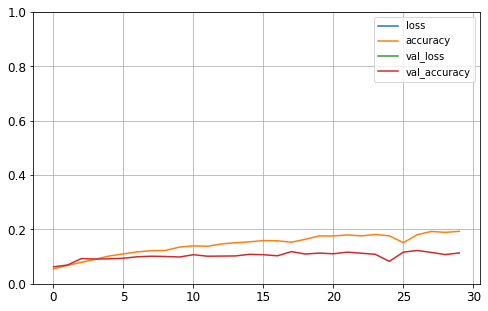

In [86]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [30]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 6ms/step - loss: 3.2460 - accuracy: 0.1075


[3.246034622192383, 0.10750000178813934]

The accuracy is not satisfying, our network obtains a good classification every ten itterations. Our dataset preset higher complexity than regular benchmark datasets such as MNIST. However, it is known that convolutional neural networks work best on image dataset.

# Using ANN and CNN

Convolutional neural network present a huge advantage over other network type due to its ability to identify patterns in multiple places on the image.This makes them really convenient for image processing.

In [77]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(20, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 conv2d_19 (Conv2D)          (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1024)             

The training uses the validation data to enhance the network, at the end of every epoch the network is verified. We also introduce a shuffling of the set at each epoch. This parameter allows for a better flexibility in the network and avoid patterns and overfitting. 

In [78]:
cnn = model2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), shuffle=True)

Epoch 1/20
500/500 [==============================] - 22s 44ms/step - loss: 3.0815 - accuracy: 0.1121 - val_loss: 2.7380 - val_accuracy: 0.1535
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 2.6830 - accuracy: 0.1740 - val_loss: 2.6878 - val_accuracy: 0.1760
Epoch 3/20
500/500 [==============================] - 19s 39ms/step - loss: 2.5999 - accuracy: 0.2086 - val_loss: 2.6477 - val_accuracy: 0.1845
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 2.5184 - accuracy: 0.2314 - val_loss: 2.6875 - val_accuracy: 0.1955
Epoch 5/20
500/500 [==============================] - 24s 48ms/step - loss: 2.4456 - accuracy: 0.2539 - val_loss: 2.6103 - val_accuracy: 0.2050
Epoch 6/20
500/500 [==============================] - 23s 47ms/step - loss: 2.3740 - accuracy: 0.2730 - val_loss: 2.6721 - val_accuracy: 0.2020
Epoch 7/20
500/500 [==============================] - 22s 45ms/step - loss: 2.2932 - accuracy: 0.2957 - val_loss: 2.6418 - val_accuracy:

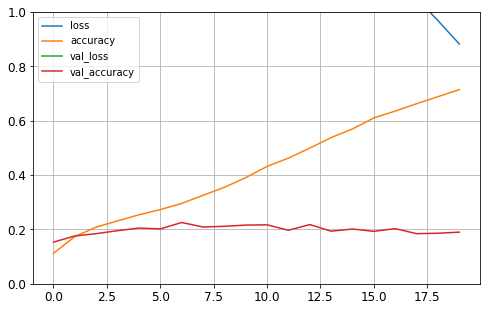

In [79]:
pd.DataFrame(cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

This graph shows that over the epochs, the network became capable of identifying the images used in his training. However, when used for new images the accurancy does not go above 20%. To achieve better results, one can improve the network design, set a higher number of epochs, lowering the learning rate and tuning its evolution over the training. The .fit() method does not allow for a change in learning rate.

In [89]:
y_prediction = model2.predict(X_test)

63/63 [==============================] - 1s 13ms/step
